## Sample Project: Credit Worthiness

A bank wants to use performance of an in-house credit product to create a risk model. A sample of applicants for the original credit product was selected. Credit bureau data describing these individuals (at the time of application) was recorded and stored in the CREDIT data set. The ultimate disposition of the loan was determined (paid off or bad debt). For loans rejected at the time of application, a disposition was inferred from credit bureau records on loans obtained in a similar time frame.

In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
from IPython.display import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score

%matplotlib inline

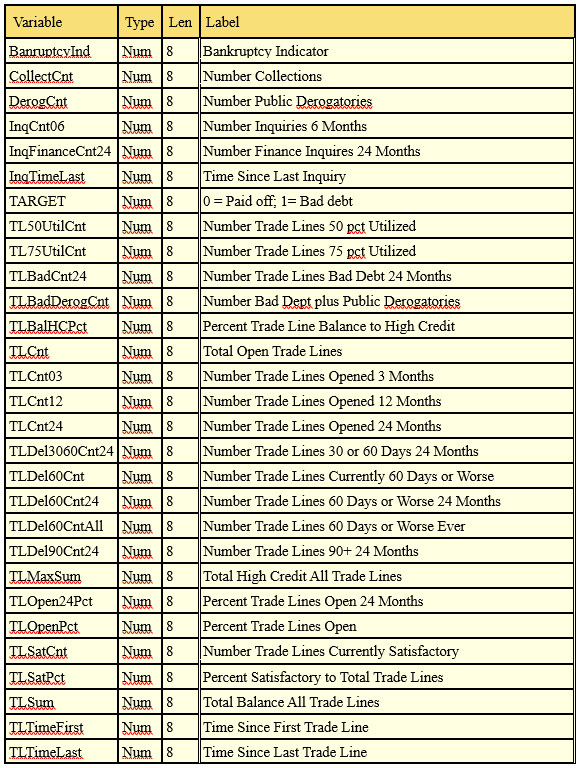

In [2]:
# variable definitions
Image(filename = 'credit_table.png', width = 400, height = 650)

### Part I: Data Cleansing

In [4]:
import pandas as pd 

Credit = pd.read_csv('Credit.csv').dropna() 
Credit.info() 

# get rid of the $ and % sign in the following columns 

Credit['TLSum'] = Credit[['TLSum']].replace('[\$,]','',regex=True).astype(float) 
Credit['TLMaxSum'] = Credit[['TLMaxSum']].replace('[\$,]','',regex=True).astype(float) 
Credit['TLBalHCPct'] = Credit['TLBalHCPct'].replace('%','',regex=True).astype('float')/100 
Credit['TLSatPct'] = Credit['TLSatPct'].replace('%','',regex=True).astype('float')/100 
Credit['TLOpenPct'] = Credit['TLOpenPct'].replace('%','',regex=True).astype('float')/100 
Credit['TLOpen24Pct'] = Credit['TLOpen24Pct'].replace('%','',regex=True).astype('float')/100 

Credit.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2728 entries, 0 to 2999
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET           2728 non-null   int64  
 1   ID               2728 non-null   int64  
 2   DerogCnt         2728 non-null   int64  
 3   CollectCnt       2728 non-null   int64  
 4   BanruptcyInd     2728 non-null   int64  
 5   InqCnt06         2728 non-null   int64  
 6   InqTimeLast      2728 non-null   float64
 7   InqFinanceCnt24  2728 non-null   int64  
 8   TLTimeFirst      2728 non-null   int64  
 9   TLTimeLast       2728 non-null   int64  
 10  TLCnt03          2728 non-null   int64  
 11  TLCnt12          2728 non-null   int64  
 12  TLCnt24          2728 non-null   int64  
 13  TLCnt            2728 non-null   float64
 14  TLSum            2728 non-null   object 
 15  TLMaxSum         2728 non-null   object 
 16  TLSatCnt         2728 non-null   float64
 17  TLDel60Cnt    

,TARGET,ID,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,...,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
0,0,66,1,1,0,7,1.0,4,125,3,...,4.0,0.85,0.67,0,0,1,0.58,0,0,0.71
1,0,116,1,1,0,2,1.0,0,252,18,...,2.0,0.48,0.30,0,1,4,0.40,2,1,0.50
2,0,124,0,0,0,1,1.0,4,254,12,...,3.0,0.84,0.67,0,1,1,0.50,1,1,0.33
3,0,128,0,0,0,6,3.0,6,154,3,...,5.0,0.73,0.76,0,1,1,0.53,1,1,1.22
4,0,143,0,0,0,1,0.0,1,311,17,...,3.0,0.88,0.63,0,0,1,0.63,0,0,0.20


In [5]:
# What percentage of observations in the sample has TARGET=1?
# apply the value_counts() function to the Credit["TARGET"] column

Credit["TARGET"].value_counts()

0    2257
1     471
Name: TARGET, dtype: int64

In [6]:
# Randomly split the dataset, so that the training dataset includes 60% of the original dataset. 

from sklearn.model_selection import train_test_split

# define the X and y variables. X includes all variables except ID and TARGET
X = Credit.drop(['TARGET', 'ID'], axis=1)
y = Credit["TARGET"]

x_columns = X.columns

# Instruction: split the dataset to training and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.6, random_state = 1)

### Part II: Decision Tree Model

In [7]:
from sklearn.tree import DecisionTreeClassifier
# Instruction: build a decision tree model with the training dataset

tree1 = DecisionTreeClassifier(max_depth = 3)
tree1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


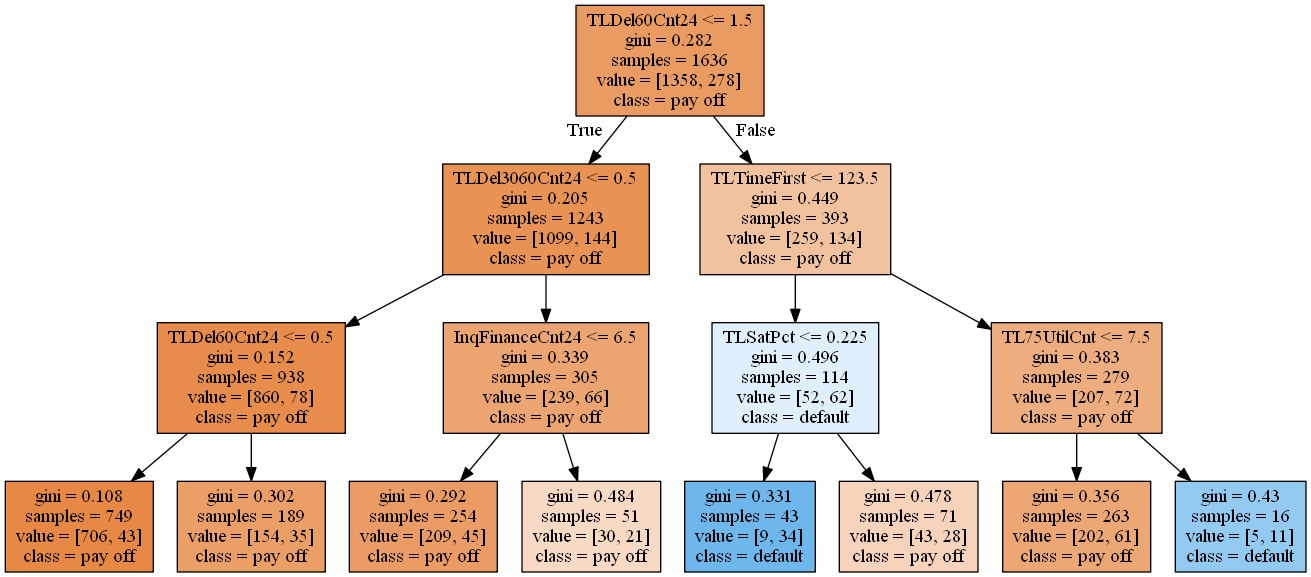

In [9]:
# Print the tree image
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

# This function creates images of tree models using pydot
def print_tree(estimator, features, class_names=None, filled=True):
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(graph)

graph = print_tree(tree1, features=x_columns, class_names=["pay off", "default"])
graph.write_png("tree.png")
Image(graph.create_png())

In [10]:
# print out the if-then conditions
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):

    '''
    feature_names: list
        The feature names of the dataset used for building the decision tree
    '''

    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)
    

tree_to_code(tree1, list(x_columns))

def tree(DerogCnt, CollectCnt, BanruptcyInd, InqCnt06, InqTimeLast, InqFinanceCnt24, TLTimeFirst, TLTimeLast, TLCnt03, TLCnt12, TLCnt24, TLCnt, TLSum, TLMaxSum, TLSatCnt, TLDel60Cnt, TLBadCnt24, TL75UtilCnt, TL50UtilCnt, TLBalHCPct, TLSatPct, TLDel3060Cnt24, TLDel90Cnt24, TLDel60CntAll, TLOpenPct, TLBadDerogCnt, TLDel60Cnt24, TLOpen24Pct):
  if TLDel60Cnt24 <= 1.5:
    if TLDel3060Cnt24 <= 0.5:
      if TLDel60Cnt24 <= 0.5:
        return [[706.  43.]]
      else:  # if TLDel60Cnt24 > 0.5
        return [[154.  35.]]
    else:  # if TLDel3060Cnt24 > 0.5
      if InqFinanceCnt24 <= 6.5:
        return [[209.  45.]]
      else:  # if InqFinanceCnt24 > 6.5
        return [[30. 21.]]
  else:  # if TLDel60Cnt24 > 1.5
    if TLTimeFirst <= 123.5:
      if TLSatPct <= 0.22500000149011612:
        return [[ 9. 34.]]
      else:  # if TLSatPct > 0.22500000149011612
        return [[43. 28.]]
    else:  # if TLTimeFirst > 123.5
      if TL75UtilCnt <= 7.5:
        return [[202.  61.]]
      else

In [11]:
# create prediction
y_pred_tree = tree1.predict(X_test)
# print model performance
# model evaluation 1: confusion matrix
print(confusion_matrix(y_test, y_pred_tree))

[[881  18]
 [179  14]]


In [12]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree).ravel()
# model evaluation 2: sensitivity & specificty
print("Accuracy = %s" %((tp+tn)/(tp+fn+tn+fp)))
print("Sensitivity = %s" %(tp/(tp+fn)))
print("Specificity = %s" %(tn/(tn+fp)))

Accuracy = 0.8195970695970696
Sensitivity = 0.07253886010362694
Specificity = 0.9799777530589544


In [13]:
# model evaluation 3: precision & recall & F1_score
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.83      0.98      0.90       899
           1       0.44      0.07      0.12       193

    accuracy                           0.82      1092
   macro avg       0.63      0.53      0.51      1092
weighted avg       0.76      0.82      0.76      1092



#### According to the tree image, explain whether applicant 66 (ID = 66; the first applicant in the data table) will default on a loan.

In [14]:
# Instruction: generate the probability for the whole dataset and save the probability in a new column
Credit["predict_prob"] = tree1.predict_proba(X)[:,1]

# Instruction: print out the first five rows. The ID = 66 is the very first record. Find out the predict_prob value for this first row
Credit[["ID","predict_prob"]].head()

,ID,predict_prob
0,66,0.057410
1,116,0.185185
2,124,0.185185
3,128,0.185185
4,143,0.057410


In [15]:
# print out variable importances
list(zip(X_train, tree1.feature_importances_))

[('DerogCnt', 0.0),
 ('CollectCnt', 0.0),
 ('BanruptcyInd', 0.0),
 ('InqCnt06', 0.0),
 ('InqTimeLast', 0.0),
 ('InqFinanceCnt24', 0.061567869152977316),
 ('TLTimeFirst', 0.17410955936176664),
 ('TLTimeLast', 0.0),
 ('TLCnt03', 0.0),
 ('TLCnt12', 0.0),
 ('TLCnt24', 0.0),
 ('TLCnt', 0.0),
 ('TLSum', 0.0),
 ('TLMaxSum', 0.0),
 ('TLSatCnt', 0.0),
 ('TLDel60Cnt', 0.0),
 ('TLBadCnt24', 0.0),
 ('TL75UtilCnt', 0.08244432113525782),
 ('TL50UtilCnt', 0.0),
 ('TLBalHCPct', 0.0),
 ('TLSatPct', 0.11079892325666978),
 ('TLDel3060Cnt24', 0.10761749034347881),
 ('TLDel90Cnt24', 0.0),
 ('TLDel60CntAll', 0.0),
 ('TLOpenPct', 0.0),
 ('TLBadDerogCnt', 0.0),
 ('TLDel60Cnt24', 0.4634618367498496),
 ('TLOpen24Pct', 0.0)]

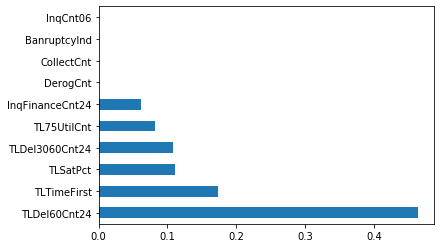

In [25]:
# We can also plot the important features
%matplotlib inline

feat_importances = pd.Series(tree1.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

### Part III: Random Forest Model

In [17]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor

# play around with the setting for max_features
for i in range(1, 11):
    rfc2 = RandomForestClassifier(max_features=i, random_state=1)
    rfc2.fit(X_train, y_train)
    pred2 = rfc2.predict(X_test)
    print("Accuracy for %s feature(s) equals %s" %(i, accuracy_score(y_test, pred2)))

Accuracy for 1 feature(s) equals 0.8305860805860806
Accuracy for 2 feature(s) equals 0.826007326007326
Accuracy for 3 feature(s) equals 0.8296703296703297
Accuracy for 4 feature(s) equals 0.8241758241758241
Accuracy for 5 feature(s) equals 0.8241758241758241
Accuracy for 6 feature(s) equals 0.826007326007326
Accuracy for 7 feature(s) equals 0.8269230769230769
Accuracy for 8 feature(s) equals 0.8305860805860806
Accuracy for 9 feature(s) equals 0.8305860805860806
Accuracy for 10 feature(s) equals 0.8278388278388278


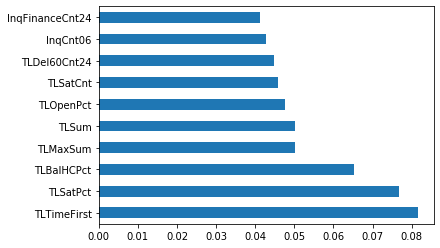

In [24]:
rfc8 = RandomForestClassifier(max_features=8, random_state=1)
rfc8.fit(X_train, y_train)

feat_importances = pd.Series(rfc8.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

## PDPBox Plot

When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

#### Plot the impact of single variable

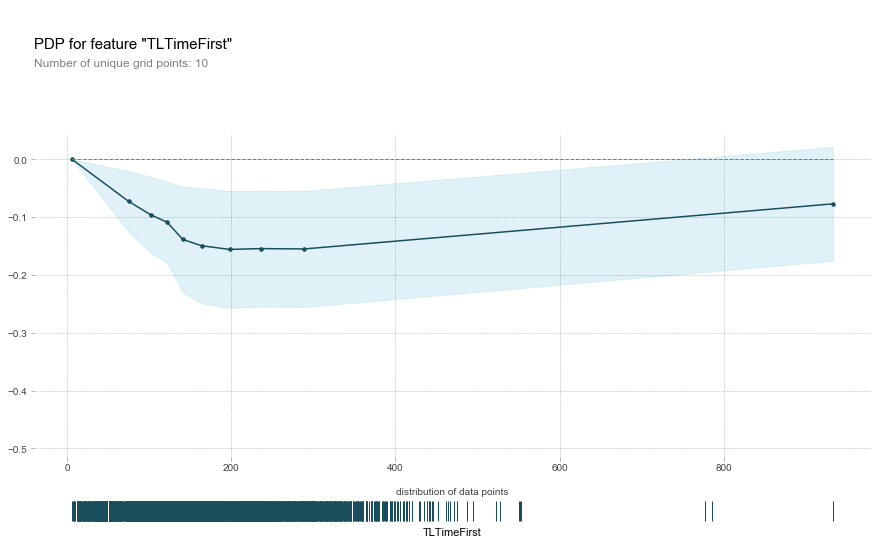

In [22]:
# https://pdpbox.readthedocs.io/en/latest/

# ModuleNotFoundError: No module named 'pdpbox'  --> pip install pdpbox

from pdpbox.pdp import pdp_isolate, pdp_plot
pdp_TimeFirst = pdp_isolate(model=rfc8, dataset=Credit, model_features=x_columns,feature='TLTimeFirst')
fig, axes = pdp_plot(pdp_isolate_out=pdp_TimeFirst,feature_name='TLTimeFirst',plot_pts_dist=True)

Target: 0-paid off, 1-Bad debt
TLTimeFirst: Time Since First Trade Line

Interpretation: When the number days sicne first trade line increases, the chance of default first decreases and then slightly increases.

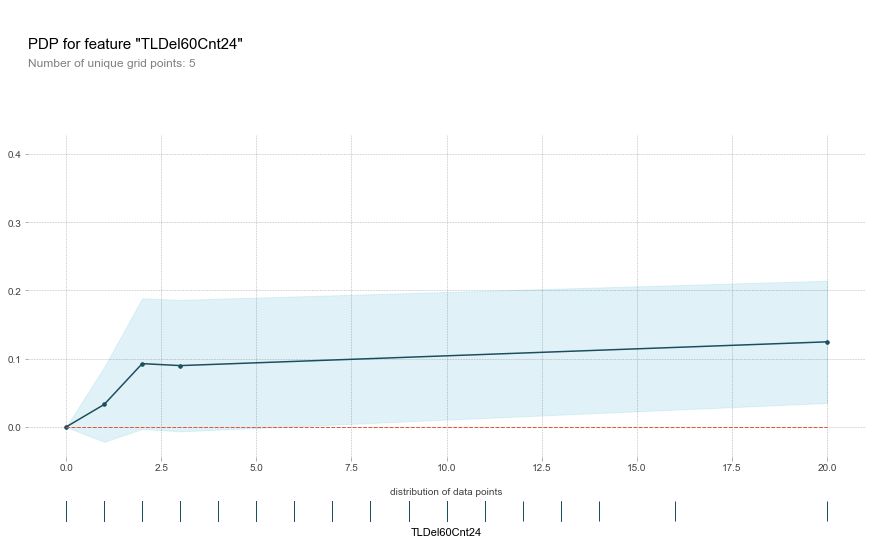

In [26]:
from pdpbox.pdp import pdp_isolate, pdp_plot
pdp_TLSatPct = pdp_isolate(model=rfc8, dataset=Credit, model_features=x_columns,feature='TLDel60Cnt24')
fig, axes = pdp_plot(pdp_isolate_out=pdp_TLSatPct,feature_name='TLDel60Cnt24',plot_pts_dist=True)

Target: 0-paid off, 1-Bad debt
TLDel60Cnt24: Number Trade Lines delinquency for 60 Days or Worse in the past 24 months

Interpretation: When the number of delinquency increases, the chance of default increases. The increase rate is higher when deliquency count is below 2. 